# Import and Preprocess

In [1]:

# Core libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# RDKit for chemical informatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdFMCS import FindMCS

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import display

# Machine learning and clustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Custom modules
from normalisation import JumpExplorer

# Set default renderer for Plotly
pio.renderers.default = 'browser'
from rdkit.Chem.Draw import DrawingOptions

# Configurer les options de dessin
options = DrawingOptions()
options.fixedScale = 0.7  # Réduire l'échelle des molécules pour plus d'espace
options.padding = 0.2 

/home/maxime/.cache/pypoetry/virtualenvs/normalisation-RVbkHmRO-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_phenom = pd.read_parquet('/home/maxime/synrepos/phenospace/normalisation/publication/data/norm_2_compounds_embeddings.parquet')


In [3]:
#df_phenom = pd.read_parquet('/projects/synsight/data/openphenom/norm_2_compounds_embeddings.parquet')


In [4]:
df_phenom['PhenotypicProfile'] = df_phenom['Embeddings_mean'].apply(
    lambda x: x.astype(np.float64) if isinstance(x, np.ndarray) else x
)

In [5]:
def compute_murcko_scaffold(inchi):
    try:
        mol = Chem.MolFromInchi(inchi)  
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)  
        return Chem.MolToSmiles(scaffold)  
    except Exception as e:
        return None  

df_phenom['Murcko_Scaffold'] = df_phenom['Metadata_InChI'].apply(compute_murcko_scaffold)

[08:40:16] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)

[08:40:22] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[08:40:26] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)

[08:40:27] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[08:40:33] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)

[08:40:34] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[08:40:36] WARNING:  Probl

In [6]:
df_phenom.drop(columns=['Metadata_Is_Control', 'path_embedding', 'Embeddings_mean'], inplace=True)

In [7]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Votre InChI
inchi_str = "InChI=1/C19H33N3O6/c1-5-9-20-16(23)14-15(28-14)17(24)21-13(11(3)6-2)18(25)22-10-7-8-12(22)19(26)27-4/h11-15,18,25H,5-10H2,1-4H3,(H,20,23)(H,21,24)"

# 1) Conversion InChI -> Mol
mol = Chem.MolFromInchi(inchi_str)

# 2) Calcul du scaffold (Bemis-Murcko)
scaffold = MurckoScaffold.GetScaffoldForMol(mol)

# 3) Extraction du SMILES
scaffold_smiles = Chem.MolToSmiles(scaffold)
print(scaffold_smiles)


C(=NCCN1CCCC1)C1CO1


In [8]:
df_phenom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112605 entries, 0 to 112604
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   112605 non-null  object
 1   Metadata_InChI     112605 non-null  object
 2   PhenotypicProfile  112605 non-null  object
 3   Murcko_Scaffold    112603 non-null  object
dtypes: object(4)
memory usage: 3.4+ MB


In [9]:
df_phenom[df_phenom['Metadata_InChI'] == "InChI=1S/C15H12N2O2/c16-15(19)17-12-7-3-1-5-10(12)9-14(18)11-6-2-4-8-13(11)17/h1-8H,9H2,(H2,16,19)"]

,Metadata_JCP2022,Metadata_InChI,PhenotypicProfile,Murcko_Scaffold
16232,JCP2022_013346,InChI=1S/C15H12N2O2/c16-15(19)17-12-7-3-1-5-10...,"[0.32751086354255676, -0.4196804165840149, 0.7...",O=C1Cc2ccccc2Nc2ccccc21


# A lot of functions

In [20]:
def filter_molecules_by_scaffold(df, scaffold_smiles):
    return df[df['Murcko_Scaffold'] == scaffold_smiles]


def compute_phenotypic_similarity(df):
    embeddings = np.stack(df['PhenotypicProfile'])  
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

# Fonction pour calculer les Tanimoto Similarities
def compute_tanimoto_similarities(df):
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromInchi(inchi), radius=2) for inchi in df['Metadata_InChI']]
    tanimoto_matrix = np.zeros((len(fps), len(fps)))
    for i in range(len(fps)):
        for j in range(i + 1, len(fps)):
            tanimoto_matrix[i, j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            tanimoto_matrix[j, i] = tanimoto_matrix[i, j]
    return tanimoto_matrix

In [21]:
def process_murkos(df, n_threshold, m_values):
    # Group by Murcko scaffold
    grouped = df.groupby('Murcko_Scaffold')
    results = []

    for scaffold, group in tqdm(grouped):
        if len(group) > n_threshold:
            phenotypic_profiles = np.stack(group['PhenotypicProfile'].values)

            # Compute similarities within and between clusters
            tanimoto_sim_matrix = compute_tanimoto_similarities(df[df['Murcko_Scaffold'] == scaffold])
            cosine_sim_matrix = cosine_similarity(phenotypic_profiles)

            for m in m_values:
                # Perform hierarchical clustering
                distance_matrix = pdist(phenotypic_profiles, metric='euclidean')
                linkage_matrix = linkage(distance_matrix, method='ward')
                cluster_labels = fcluster(linkage_matrix, m, criterion='maxclust')
                
                # Check if any cluster has fewer than 3 molecules
                cluster_sizes = np.bincount(cluster_labels)[1:]  # Cluster sizes, excluding cluster 0
                if np.any(cluster_sizes < 3):
                    continue  # Skip this clustering

                intra_tanimoto = []
                intra_cosine = []
                inter_tanimoto = []
                inter_cosine = []

                for cluster in range(1, m + 1):
                    indices = np.where(cluster_labels == cluster)[0]
                    if len(indices) > 1:
                        # Mask diagonal for intra-cluster calculations
                        mask = np.ones((len(indices), len(indices)), dtype=bool)
                        np.fill_diagonal(mask, False)
                        intra_tanimoto.append(np.mean(tanimoto_sim_matrix[np.ix_(indices, indices)][mask]))
                        intra_cosine.append(np.mean(cosine_sim_matrix[np.ix_(indices, indices)][mask]))
                for i in range(1, m + 1):
                    for j in range(i + 1, m + 1):
                        indices_i = np.where(cluster_labels == i)[0]
                        indices_j = np.where(cluster_labels == j)[0]
                        if indices_i.size > 0 and indices_j.size > 0:
                            inter_tanimoto.append(np.mean(tanimoto_sim_matrix[np.ix_(indices_i, indices_j)]))
                            inter_cosine.append(np.mean(cosine_sim_matrix[np.ix_(indices_i, indices_j)]))

                results.append({
                    'Scaffold': scaffold,
                    'n_Scaffold': len(group),
                    'ClusterCount': m,
                    'IntraTanimoto': np.mean(intra_tanimoto) if intra_tanimoto else None,
                    'IntraCosine': np.mean(intra_cosine) if intra_cosine else None,
                    'InterTanimoto': np.mean(inter_tanimoto) if inter_tanimoto else None,
                    'InterCosine': np.mean(inter_cosine) if inter_cosine else None
                })
    return pd.DataFrame(results)


In [51]:
def plot_analysis(results_df):
    plt.style.use('default')  # Clean and simple aesthetic

    fig1, ax1 = plt.subplots(figsize=(15, 8))

    selected = results_df['Selected_Scaffold']
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.grid(True, linestyle='--', alpha=0.7)  # Add grid
    ax1.plot(
        [0, 0.82], [0, 0.82],  # Diagonal line y = x
        color='black', linewidth=2, alpha=0.8, label='y = x'
    )

 #   ax1.plot(
 #       [0.3, 0.8], [0.1, 0.6],  # Offset line y = x - 0.2
 #       color='red', linestyle='--', linewidth=1, alpha=0.8, label='y = x - 0.2'
 #   )

    ax1.set_ylim(-0.2, 0.82)
    ax1.set_xlim(0, 0.8)

    ax1.scatter(
        results_df.loc[~selected, 'IntraTanimoto'], results_df.loc[~selected, 'InterTanimoto'],
        alpha=0.3, s=100, edgecolors='k', color='gray', marker='x'
    )
    ax1.scatter(
        results_df.loc[selected, 'IntraTanimoto'], results_df.loc[selected, 'InterTanimoto'],
        alpha=0.8, s=100, edgecolors='k', color='blue'
    )

    ax1.legend(fontsize=30, loc='upper left', frameon=True, framealpha=0.9)  # Increased font size

    plt.tight_layout()
    plt.savefig("structural_tanimoto_plot.pdf", format="pdf", dpi=300)  # Save the plot as a high-res PDF
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(15, 8))
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.grid(True, linestyle='--', alpha=0.7)  # Add grid
    ax2.set_xlim(0, 0.8)
    ax2.set_ylim(-0.2, 0.82)

    ax2.plot(
        [0, 0.8], [0, 0.8],  # Diagonal line y = x
        color='black', linewidth=2, alpha=0.8, label='y = x'
    )

    ax2.plot(
        [0, 0.8], [-0.2, 0.6],  # Offset line y = x - 0.2
        color='black', linestyle='--', linewidth=1, alpha=0.8, label='y = x - 0.2'
    )

    ax2.scatter(
        results_df.loc[~selected, 'IntraCosine'], results_df.loc[~selected, 'InterCosine'],
        alpha=0.3, s=100, edgecolors='k', color='gray', marker='x'
    )
    ax2.scatter(
        results_df.loc[selected, 'IntraCosine'], results_df.loc[selected, 'InterCosine'],
        alpha=0.8, s=100, edgecolors='k', color='darkred'
    )

    ax2.legend(fontsize=30, loc='upper left', frameon=True, framealpha=0.9)  # Increased font size

    plt.tight_layout()
    plt.savefig("phenotypic_cosine_plot.pdf", format="pdf", dpi=300)  # Save the plot as a high-res PDF
    plt.show()


# Find Murko Cluster

In [24]:
scaffold_counts = df_phenom['Murcko_Scaffold'].value_counts()
scaffold_counts.head(5)


Murcko_Scaffold
c1ccccc1                      1351
                               391
c1ccncc1                       216
O=S(=O)(Nc1ccccc1)c1ccccc1     158
C(=Nc1ccccc1)c1ccccc1          157
Name: count, dtype: int64

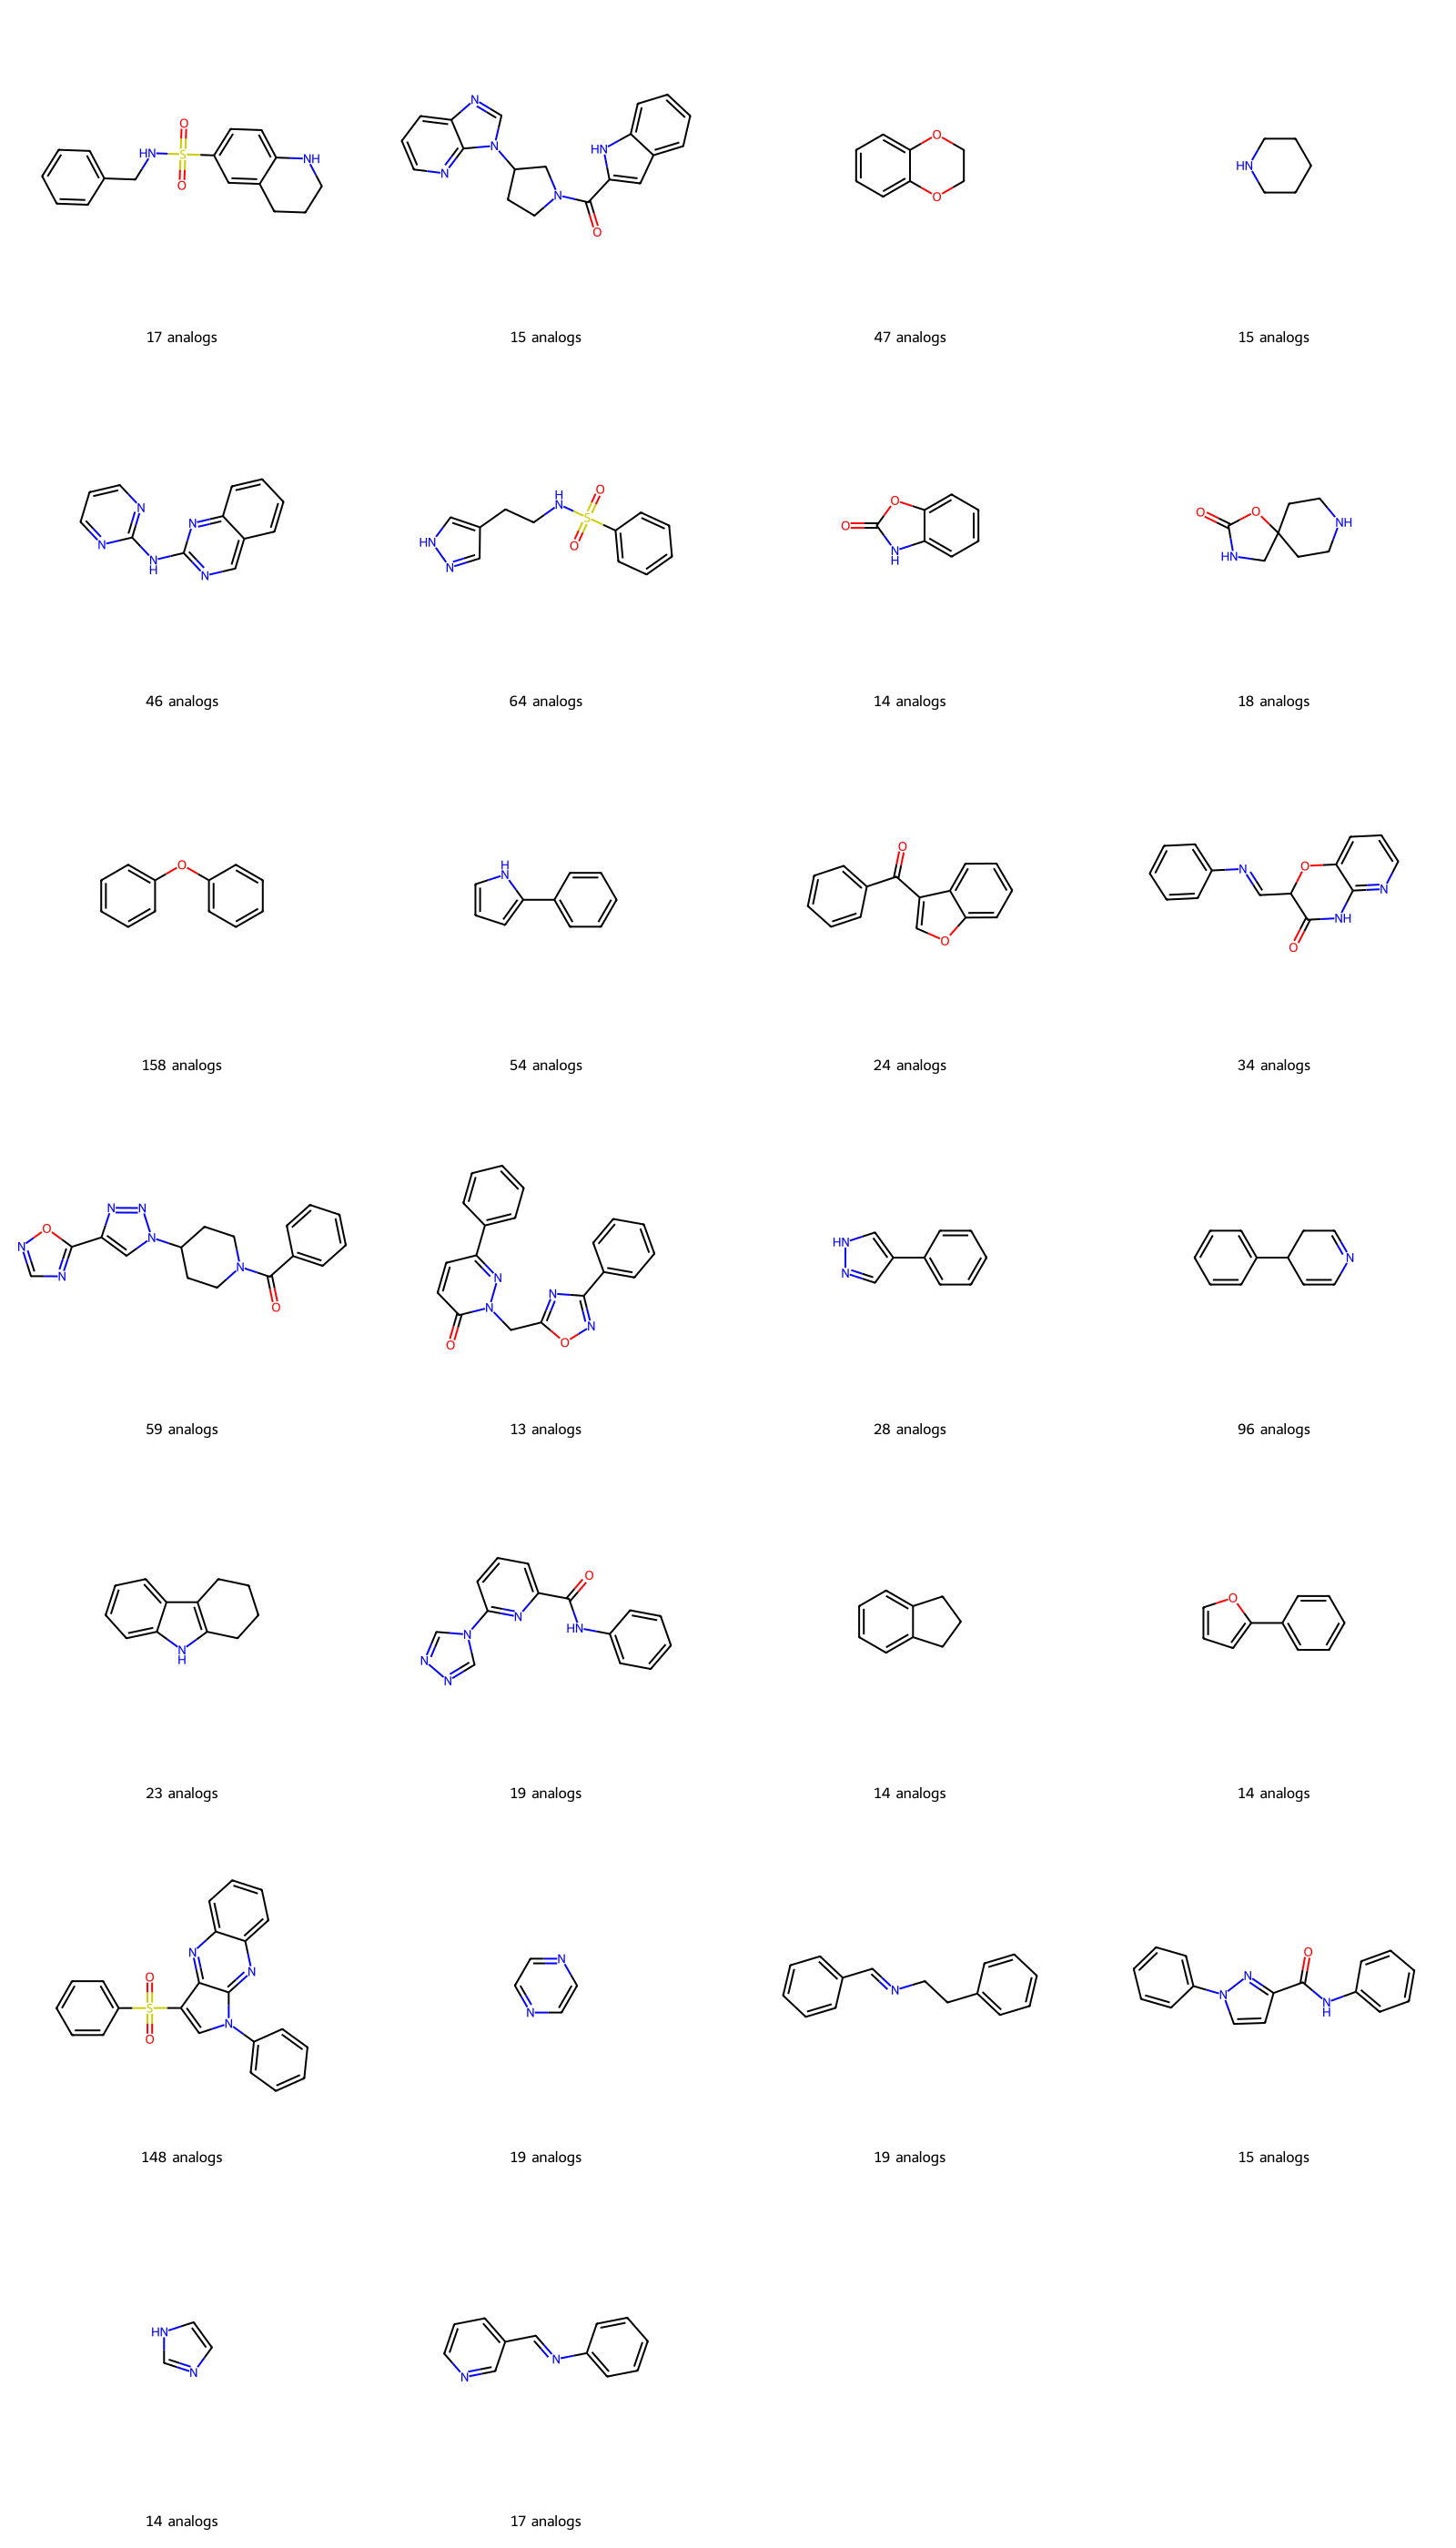

In [26]:

top_scaffolds = scaffold_counts.head(400).sample(28).index
frequencies = scaffold_counts.head(400).sample(28).values
mols = [Chem.MolFromSmiles(smiles) for smiles in top_scaffolds]

legends = [f"{freq} analogs" for freq in frequencies]

img = Draw.MolsToGridImage(mols[2:], molsPerRow=4, subImgSize=(400, 400), legends=legends[2:])

display(img)

# Scrapping Scaffold

In [28]:
n_threshold = 6  # Minimum number of molecules per group
m_values = [2]  # Possible number of clusters
results_df = process_murkos(df_phenom, n_threshold, m_values)[1:]
results_df['TanimotoDifference'] = results_df['IntraTanimoto'] - results_df['InterTanimoto']
results_df['CosineDifference'] = results_df['IntraCosine'] - results_df['InterCosine']
results_df['Selected_Scaffold'] = (results_df['CosineDifference'] > 0.2) & (results_df['IntraCosine'] > 0.2)


 20%|██        | 14931/74653 [00:03<00:12, 4888.05it/s][08:44:30] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)

100%|██████████| 74653/74653 [00:18<00:00, 4014.43it/s] 


In [30]:
selected_clusters = results_df[(results_df['CosineDifference']>0.2) & (results_df['IntraCosine']>0.2)]

In [33]:
results_df['selected_clusters'] = (results_df['CosineDifference']>0.2) & (results_df['IntraCosine']>0.2)

In [31]:
selected_clusters['n_Scaffold'].sum() - 1351

2277

In [32]:
len(selected_clusters)

81

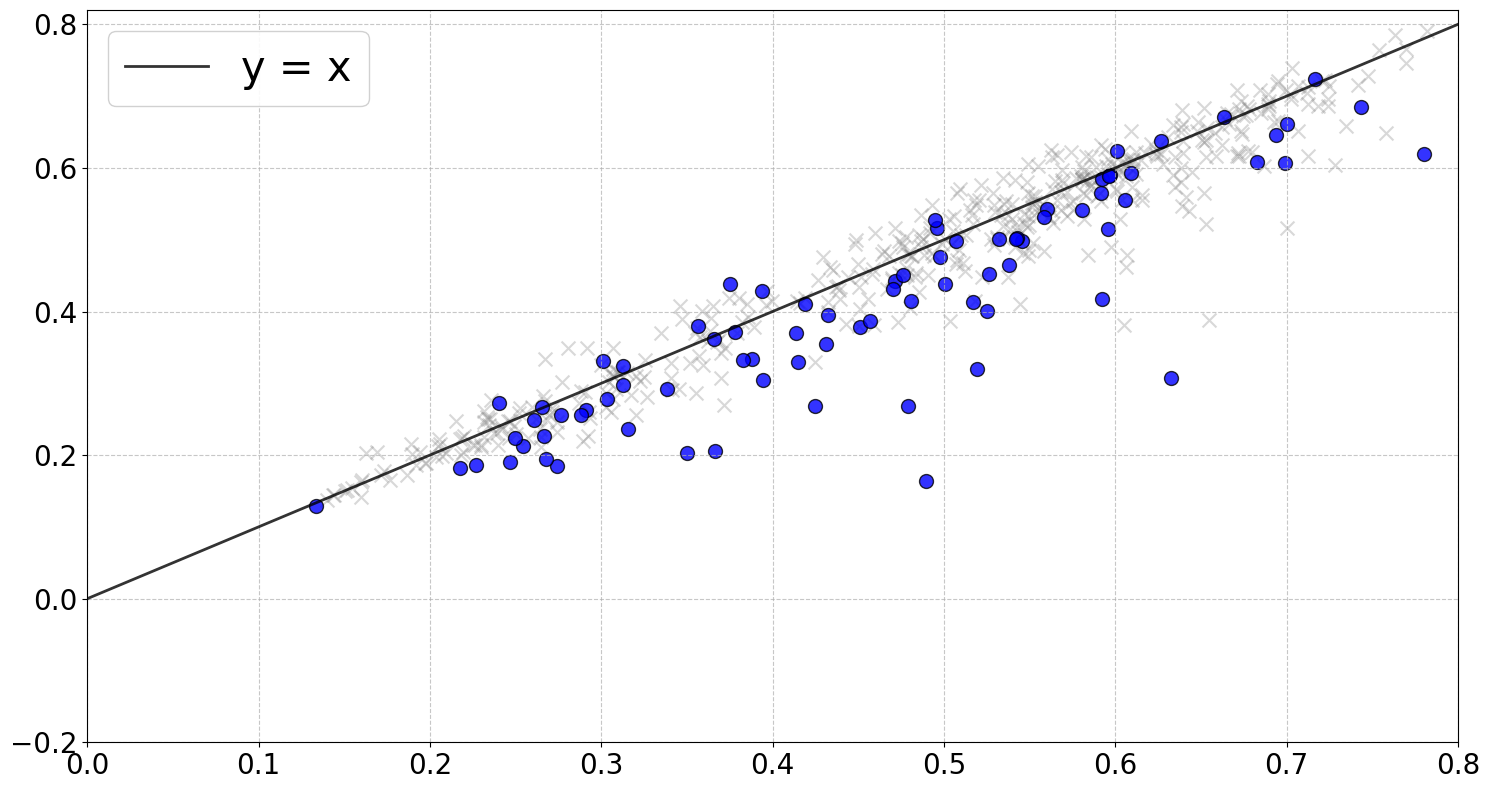

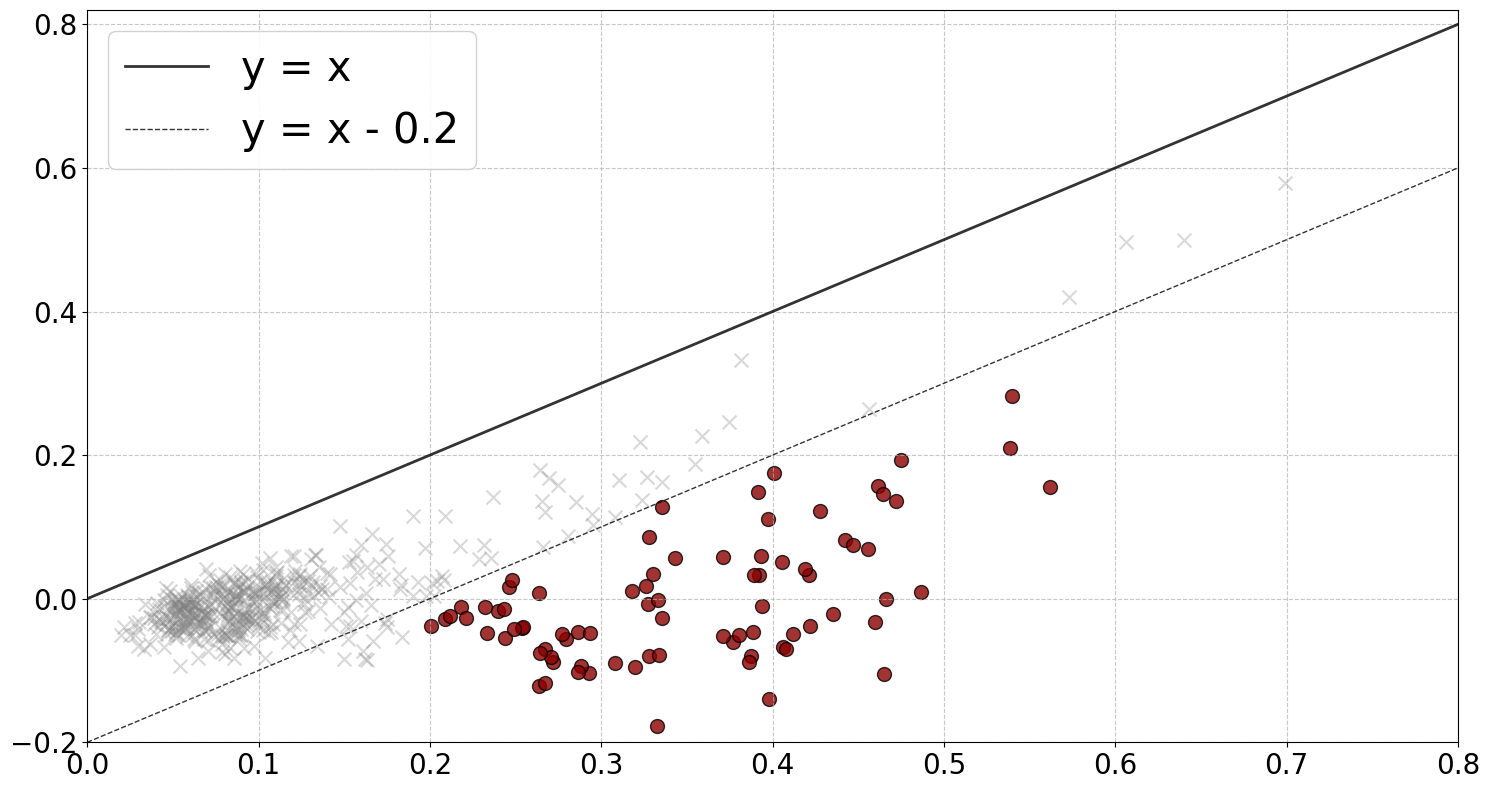

In [52]:
plot_analysis(results_df)


In [37]:
selected_clusters.sample()[['Scaffold', 'IntraCosine','InterCosine',  'IntraTanimoto','InterTanimoto']]

,Scaffold,IntraCosine,InterCosine,IntraTanimoto,InterTanimoto
367,c1ccc(-c2c[nH]nc2-c2ccccc2)cc1,0.46523,-0.104548,0.338667,0.292617


In [ ]:
# Create interactive scatter plot
fig = px.scatter(
    selected_clusters[:80],
    x='IntraTanimoto',
    y='InterTanimoto',
    size='n_Scaffold',  # Set size proportional to n_Scaffold
    hover_data={
        'Scaffold': True,
        'n_Scaffold': True,
        'ClusterCount': True,
        'IntraTanimoto': False,  # Prevents redundancy in tooltip
        'InterTanimoto': False   # Prevents redundancy in tooltip
    },
    labels={
        'IntraTanimoto': 'Intra-cluster Similarity',
        'InterTanimoto': 'Inter-cluster Similarity'
    },
    title='Tanimoto Similarity: Intra vs. Inter-cluster',
    size_max=20  # Optional: Adjust the maximum marker size for better visibility
)

# Add y = x line (dashed and light)
fig.add_shape(
    type='line',
    x0=0.2, y0=0.2, x1=0.8, y1=0.8,  # Line from (0,0) to (1,1)
    line=dict(color='gray', dash='dash', width=1),
    xref='x', yref='y'
)

# Customize layout
fig.update_traces(marker=dict(line=dict(width=1, color='Black')))
fig.update_layout(
    xaxis_title='Intra-cluster Similarity',
    yaxis_title='Inter-cluster Similarity',
    title_font_size=18,
    font=dict(size=12),
    legend=dict(font=dict(size=14)),
    hoverlabel=dict(font_size=14)
)

# Show the plot
fig.show()


In [ ]:
# Create interactive scatter plot
fig = px.scatter(
    selected_clusters[:80],
    x='IntraCosine',
    y='InterCosine',
    size='n_Scaffold',  # Set size proportional to n_Scaffold
    hover_data={
        'Scaffold': True,
        'n_Scaffold': True,
        'ClusterCount': True,
        'IntraCosine': False,  # Prevents redundancy in tooltip
        'InterCosine': False   # Prevents redundancy in tooltip
    },
    labels={
        'IntraCosine': 'Intra-cluster Similarity',
        'InterCosine': 'Inter-cluster Similarity'
    },
    title='Tanimoto Similarity: Intra vs. Inter-cluster',
    size_max=20  # Optional: Adjust the maximum marker size for better visibility
)

# Add y = x line (dashed and light)
fig.add_shape(
    type='line',
    x0=0.2, y0=0.2, x1=0.6, y1=0.6,  # Line from (0,0) to (1,1)
    line=dict(color='gray', dash='dash', width=1),
    xref='x', yref='y'
)

# Customize layout
fig.update_traces(marker=dict(line=dict(width=1, color='Black')))
fig.update_layout(
    xaxis_title='Intra-cluster Similarity',
    yaxis_title='Inter-cluster Similarity',
    title_font_size=18,
    font=dict(size=12),
    legend=dict(font=dict(size=14)),
    hoverlabel=dict(font_size=14)
)

# Show the plot
fig.show()
